# Rabi Oscillation

This notebook contains some simulation about the rabi oscillation. We will use the ARC package to calculate some parameters of rydberg atoms. In order to do this, we first need to download and install the [ARC](https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/#) package.

## Two-level Rabi Oscillation
For a two-level system transition induced by a pertubation hamiltonian $H'$, we can establish the following differential equations:

$$i\hbar \frac{dc_1(t)}{dt}=\frac{H'_{11}}{2}c_1(t)[e^{i\omega t}+e^{-i\omega t}]+\frac{H'_{12}}{2}c_2(t)[e^{i(\omega-\omega_0)t}+e^{-i(\omega+\omega_0)}]$$
$$i\hbar \frac{dc_2(t)}{dt}=\frac{H'_{22}}{2}c_2(t)[e^{i\omega t}+e^{-i\omega t}]+\frac{H'_{21}}{2}c_1(t)[e^{i(\omega+\omega_0)t}+e^{-i(\omega-\omega_0)}]$$

This step is exact.

For a electric dipole approximationa and rotating wave approximation, we can write the above differential equations as
$$i\frac{dc_1}{dt}=\frac{\Omega}{2}e^{i(\omega-\omega_0)t}c_2$$
$$i\frac{dc_2}{dt}=\frac{\Omega}{2}e^{-i(\omega-\omega_0)t}c_1$$

where $\Omega=\frac{dE}{\hbar}$ is the Rabi frequency, given by
$$\Omega=-\frac{\Epsilon_0}{\hbar}\braket{1|\hat{d}_z|2}$$



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np  # Import Numerical Python
from IPython.display import display, HTML  # Import HTML for formatting output
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from scipy.integrate import ode  # Import ODE solver
import scipy.constants as cts  # Import physical constants

Let's use Rubdium  as an example. We will show the rabi oscillation between the ground state and $nP_{1/2}$. We use a 1W laser focused to a $1\mu m$ spotm size. We assume a uniform intensity distribution, so the intensity would be $I=\frac{P}{\pi w^2}=1.2732 \times 10^{8} W/m^2$. And we get $I = 1/2 \epsilon c\Epsilon_0^2$, and we get the electric field $\Epsilon_0 = 3.097 \times 10^9$.

In [2]:
I= 1.2732e8 #Intensity of the laser in W/m^2

a_0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second
E_0 = np.sqrt(2*I/(epsilon*c))  # Strength of the electric field in V/m
print('E_0=' + str(E_0))

E_0=309726.6650970364


We can write down the differential equations for the rabi oscillation.

In [3]:
# Write down the differential equation
def model(t,y,Omega,omega_0,omega):
    """Write down the differential equations of the rabi oscillation 
        
        Args:
            t (float): time
            y (list): list of the two complex amplitudes of the two states
            Omega (float): Rabi frequency
            omega_0 (float): transition frequency
            omega (float): frequency of the laser

        Returns:
            dydt (list): list of the derivatives of the two complex amplitudes

    """
    
    delta = omega - omega_0 # detuning
    c1=y[0]
    c2=y[1]
    dc1dt=-1j/2*Omega*np.exp(1j*delta*t)*c2
    dc2dt=-1j/2*Omega*np.exp(-1j*delta*t)*c1
    dydt=[dc1dt,dc2dt]
    return dydt




We can use ARC package to calculate the relevant parameters for Rubidium.

In [4]:

# for n=2, Rb
atom = Rubidium()

n1 = 5 # principal quantum number of the initial state
l1 = 0 # orbital angular momentum of the initial state
j1 = 0.5 # total angular momentum of the initial state
mj1 = 0.5 # projection of the total angular momentum of the initial state
n2 = 5 # principal quantum number of the final state
l2 = 1 # orbital angular momentum of the final state
j2 = 0.5 # total angular momentum of the final state
mj2 = 0.5 # projection of the total angular momentum of the final state
q = 0 # polarization of the laser

# Get the dipole matrix element in units of a_0e
d12=atom.getDipoleMatrixElement(
            n1=n1, l1=l1, j1=j1, mj1=mj1, n2=n2, l2=l2, 
            j2=j2, mj2=mj2,q=q
            )
print(f'd12={("{:e}".format(d12))}')  

# Get the Rabi frequency

Omega=d12*E_0/hbar * a_0*e
print('Omega='+ str("{:e}".format(Omega)))

# Or we get the rabi frequency directly
Omega=atom.getRabiFrequency(
    n1=n1, l1=l1, j1=j1, mj1=mj1, n2=n2, l2=l2, j2=j2, 
    q=q, laserPower=0.001,laserWaist=100e-6
    )

# Get the transition frequency
omega_0=-atom.getTransitionFrequency(
    n1=1, l1=0, j1=0.5, n2=2, l2=1, j2=0.5
    )
print('omega_0='+ str("{:e}".format(omega_0)))

d12=1.727748e+00
Omega=4.302236e+10
omega_0=1.158469e+15


We can write down the detuning as $\delta = \omega-\omega_0=m\Omega$.

In [6]:
# Resonant transition when m=0
m = 5
#Omega=1.542220e+10
#omega_0=1.158469e+15
#detuning
delta = m * Omega
omega = omega_0 + delta
print(f'delta={("{:e}".format(delta))}')

delta=4.810121e+09


## Solve the differential equation

Then we can solve the differential equations and plot the solution. We use ode solver from scipy package.

In [7]:
# Solve the ODE
# Initial conditions
y0=[1,0]
t=np.linspace(0,10*np.pi/Omega,10000)
r=ode(model).set_integrator('zvode')
r.set_initial_value(y0).set_f_params(Omega,omega_0,omega)
#store the results
c1 = np.zeros(len(t),dtype=complex)
c2 = np.zeros(len(t),dtype=complex)
c1[0] = y0[0]
c2[0] = y0[1]

#integration
for i in range(1,len(t)):
    r.integrate(t[i])
    
    c1[i]=r.y[0]
    c2[i]=r.y[1]







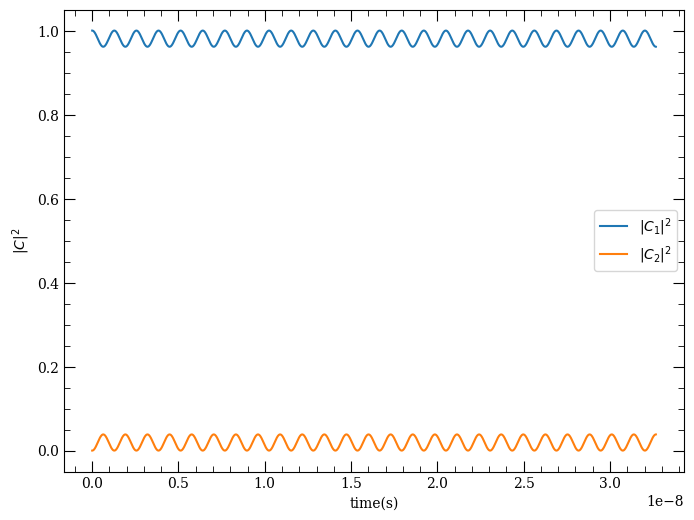

In [8]:
# Plot the results
figure=plt.figure(figsize=(8,6))
plt.plot(t,np.abs(c1)**2,label=r'$|C_1|^2$')
plt.plot(t,np.abs(c2)**2,label=r'$|C_2|^2$')
plt.xlabel('time(s)')
plt.ylabel('$|C|^2$')
plt.legend(loc = 5)
plt.show()

In [9]:
# The value of c1 for the pi pulse
c1pi = np.interp(np.pi/Omega, t, c1)
print(f'c1pi={c1pi}')
print(f'c1pi^2={np.abs(c1pi)**2}')
    

c1pi=(0.968743145530222-0.15491296871961366j)
c1pi^2=0.962461309889313


For diffrerent values of detuning , we can create an animation to demonstrate the effect.

In [10]:
# Creates animation showing the effect of different detunings
%matplotlib notebook
from matplotlib import animation
period = 10*np.pi/Omega
def detuning_func(m, Omega, omega_0, y0, T):
    t=np.linspace(0,T,10000)
    omega = omega_0 + m * Omega
    r=ode(model).set_integrator('zvode')
    r.set_initial_value(y0).set_f_params(Omega,omega_0,omega)
    #store the results
    c1 = np.zeros(len(t),dtype=complex)
    c2 = np.zeros(len(t),dtype=complex)
    c1[0] = y0[0]
    c2[0] = y0[1]

    #integration
    for i in range(1,len(t)):
        r.integrate(t[i])
        
        c1[i]=r.y[0]
        c2[i]=r.y[1]
    return t, c1, c2
    

def update(m, Omega, omega_0, y0):
    
    t, c1, c2 = detuning_func(m, Omega, omega_0, y0, T=period)
    line1.set_data(t,np.abs(c1)**2)
    line2.set_data(t,np.abs(c2)**2)
    detuning.set_text("detuning = {:0.2f} * Rabi Frequency".format(m))
    return line1, line2,

fig, ax = plt.subplots()
line1, = ax.plot([], [], label=r'$|C_1|^2$')
line2, = ax.plot([], [], label=r'$|C_2|^2$')
detuning = ax.annotate(0, xy = (0.3e-9,1.1), xytext=(0.3e-9,1.1))

ani = animation.FuncAnimation(fig, update, frames = np.arange(0, 7, 0.1),
                         fargs=(Omega, omega_0, y0), interval=100, blit=True)

tperiod = 10*np.pi/Omega
ax.set_xlim(-0.3*tperiod,1.3*tperiod)
ax.set_ylim(-0.3, 1.3)
plt.xlabel('time(ns)')
plt.ylabel('$|C|^2$')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>

We can show the effect of pi pulse as a function of the detuning.

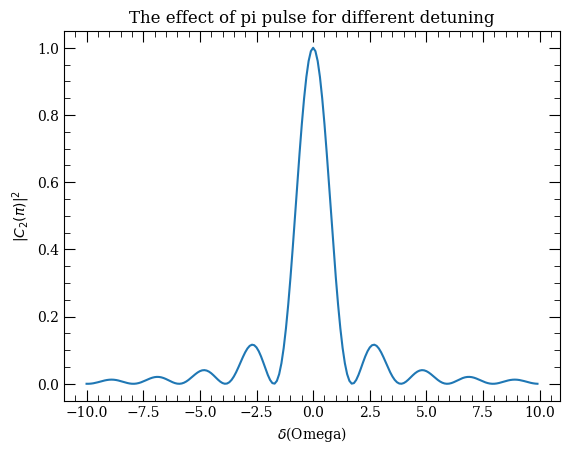

In [11]:
# Plot the c1pi for different detuning effects
%matplotlib inline
c2pi = []
ms = np.arange(-10, 10, 0.1)
for m in ms:
    t, c1, c2 = detuning_func(m, Omega, omega_0, y0, T=period)
    c2pi.append(np.interp(np.pi/Omega, t, c2))

plt.plot(ms, np.abs(c2pi)**2)
plt.xlabel('$\delta$(Omega)')
plt.ylabel('$|C_2(\pi)|^2$')
plt.title('The effect of pi pulse for different detuning')
plt.show()

    
